In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt


def plot_diffusion(x_values, result_matrix, title, time_arr=None):
    """
    Plot diffusion for given time steps

    x_values        array with x values
    result_matrix   matrix shape: number of time steps times number of x values
    """

    if time_arr is None:
        time_arr = [22, 45, 90]

    plt.figure()
    plt.plot(x_values, result_matrix[0, :], label="Initial condition")
    for i in time_arr:
        plt.plot(x_values, result_matrix[i, :], label='After {} time steps'.format(i))
    plt.legend()
    plt.xlabel('distance')
    plt.ylabel('concentration')
    plt.title(title)
    plt.grid(True)
    plt.show()


def sim_constant_d(nx, dx, l, dt, nt, d, u0=0, ul=0, q0=0, ql=0, boundary_condition="dirichlet"):
    """
    Simulate 1D diffusion with constant d

    :param nx: number of x values
    :param dx: resolution in space
    :param l: maximum x value (minimum x value: 0)
    :param dt: resolution in time
    :param nt: number of time steps
    :param u0: boundary condition at x=0
    :param ul: boundary condition at x=l
    :param q0: boundary condition at x=0
    :param ql: boundary condition at x=l
    :param d: diffusion parameter
    :param boundary_condition: type of boundary condition
    :return: array with x values, resulting values as matrix shape: number of time steps times number of x values
    """

    # space coordinates
    x_arr = np.arange(0, l+dx, dx)

    # create time times space matrix
    # nt+1 that initial conditions in first column
    # nx+1 that boundaries at x=0 and x=L
    U_mat = np.zeros([nt+1, nx+1])

    # initial conditions
    U_mat[0, x_arr > 1.5] = 3.0
    U_mat[0, x_arr >= 2.5] = 0.0

    # setup matrix
    c = d*dt/dx**2
    di = [1+2*c]*(nx+1)  # diagonal values
    su = [-c]*nx  # sub diagonal values
    M = np.diag(di, k=0) + np.diag(su, k=1) + np.diag(su, k=-1)

    if boundary_condition == "neumann":
        M[0, 0] = 1+c
        M[-1, -1] = 1+c

    M_inv = la.inv(M)  # invert matrix

    # simulate
    if boundary_condition == "dirichlet":
        for i in range(0, nt):

            # boundary condition
            U_mat[i, 0] += c*u0
            U_mat[i, -1] += c*ul

            U_mat[i+1, :] = np.dot(M_inv, U_mat[i, :])

    elif boundary_condition == "neumann":
        for i in range(0, nt):

            # boundary condition
            U_mat[i, 0] += -q0*dt/dx  # should be + but is -
            U_mat[i, -1] += ql*dt/dx  # should be - bus it +

            U_mat[i+1, :] = np.dot(M_inv, U_mat[i, :])

    return x_arr, U_mat


def sim_dirichlet_variable_d(nx, dx, l, dt, nt, u0, ul, d):
    """
    Simulate 1D diffusion with variable d

    :param nx: number of x values
    :param dx: resolution in space
    :param l: maximum x value (minimum x value: 0)
    :param dt: resolution in time
    :param nt: number of time steps
    :param u0: initial condition at x=0
    :param ul: initial condition at x=L
    :param d: diffusion parameter
    :return: array with x values, resulting values as matrix shape: number of time steps times number of x values
    """

    # space coordinates
    x_arr = np.arange(0, l+dx, dx)

    # create time times space matrix
    # nt+1 that initial conditions in first column
    # nx+1 that boundaries at x=0 and x=L
    U_mat = np.zeros([nt+1, nx+1])

    # initial conditions
    U_mat[0, x_arr > 1.5] = 3.0
    U_mat[0, x_arr >= 2.5] = 0.0

    # setup matrix
    cr = dt / dx**2 * d[1:]     # d+1/2
    cl = dt / dx**2 * d[:-1]   # d-1/2
    ca = np.add(cl, cr)

    di = np.add(ca, 1)  # diagonal values
    sl = -cl[1:]       # lower sub diagonal values
    sr = -cr[:-1]      # upper sub diagonal values

    M = np.diag(di, k=0) + np.diag(sr, k=1) + np.diag(sl, k=-1)

    # invert matrix
    M_inv = la.inv(M)

    for i in range(0, nt):

        # boundary conditions
        U_mat[i, 0] += cl[0]*u0
        U_mat[i, -1] += cr[l]*ul

        U_mat[i+1, :] = np.dot(M_inv, U_mat[i, :])

    return x_arr, U_mat

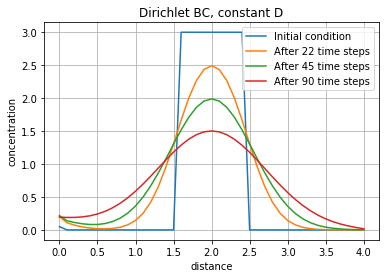

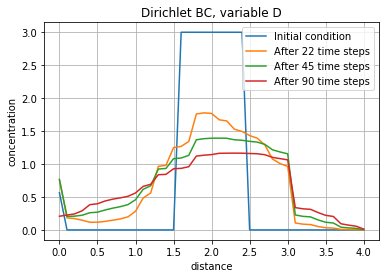

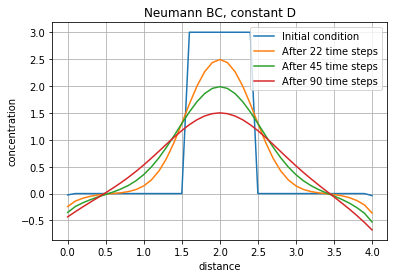

In [2]:
# set parameters
nx = 40
dx = 0.1
l = 4
dt = 0.025
nt = 90
u0 = 0.2
ul = 0.0

# Dirichlet boundary conditions
# constant D
d = 0.1
x, U = sim_constant_d(nx=nx, dx=dx, l=l, dt=dt, nt=nt, u0=u0, ul=ul, d=d, boundary_condition="dirichlet")
plot_diffusion(x_values=x, result_matrix=U, title='Dirichlet BC, constant D')

# variable D
d = np.random.lognormal(mean=-1, sigma=1, size=nx + 2)
x, U = sim_dirichlet_variable_d(nx=nx, dx=dx, l=l, dt=dt, nt=nt, u0=u0, ul=ul, d=d)
plot_diffusion(x_values=x, result_matrix=U, title='Dirichlet BC, variable D')

# Neumann boundary conditions
# constant D
d = 0.1
q0 = 0.1
ql = -0.15
x, U = sim_constant_d(nx=nx, dx=dx, l=l, dt=dt, nt=nt, q0=q0, ql=ql, d=d, boundary_condition="neumann")
plot_diffusion(x_values=x, result_matrix=U, title='Neumann BC, constant D')